In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=c2d616c1982d286bb2d8d2c6b42700e774e8d609686fc3d61db872ecfe47fd90
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Dogs vs Cats**


---

The Dogs vs Cats dataset was hosted by Kaggle as part of a [competition](https://www.kaggle.com/c/dogs-vs-cats/overview) that was held in 2013. The task was to train a model that can classify pictures of dogs and cats and was originally used as a CAPTCHA (i.e. a test to distinguish between human and machine). The winning submission achieved an accuracy of almost 99% while the previous state-of-the-art performance was about 80%.

Here we will explore the dataset and see what kind of performance we can achieve with simple convolutional neural networks, using Keras.

The dataset consists of 25000 labeled images for training (50% dogs and 50% cats) and 12500 unlabeled images for testing. We are going to create a testing subset out of the training dataset and use that to evaluate performance.




In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 792M/812M [00:04<00:00, 179MB/s]
100% 812M/812M [00:04<00:00, 190MB/s]


Import the relevant libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%load_ext tensorboard

import os
import shutil
import zipfile
import time

In [ ]:
# unzip the training images

local_zip = '/content/dogs-vs-cats.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref1 = zipfile.ZipFile('/content/train.zip', 'r')
zip_ref1.extractall('/content')
zip_ref1.close()

In [ ]:
os.mkdir('/content/train/cats')
os.mkdir('/content/train/dogs')

for filename in os.listdir('/content/train'):
  if filename.startswith('cat'):
    shutil.move('/content/train'+'/'+filename, '/content/train/cats')
  else:
    shutil.move('/content/train'+'/'+filename, '/content/train/dogs')

Let's visualize some the pictures from each class.

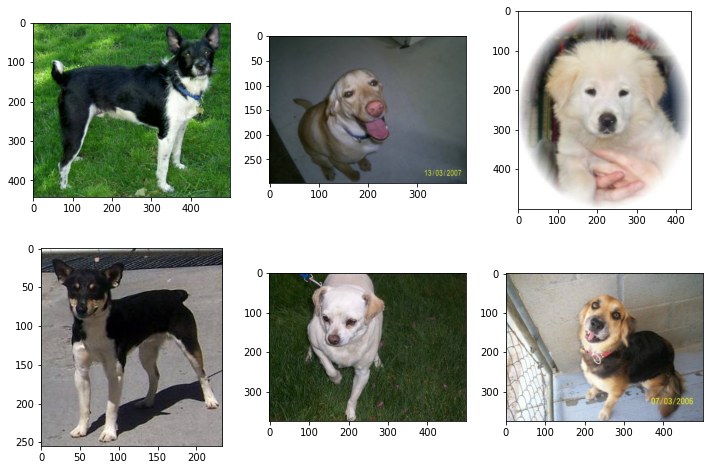

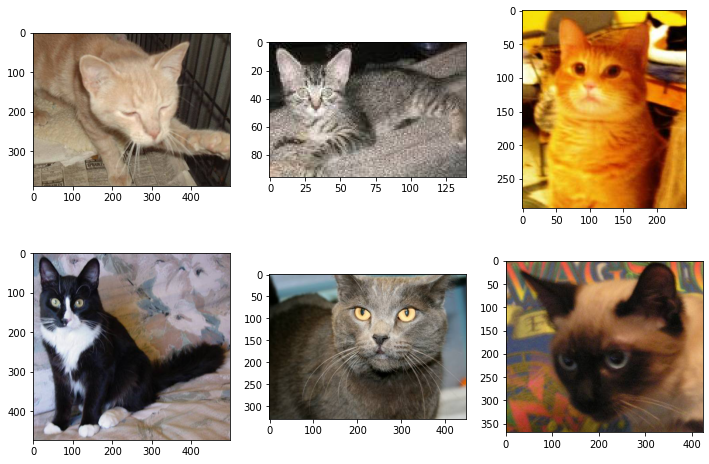

In [ ]:
import matplotlib.image as mpimg

directory=os.listdir('/content/train/')
for each in directory:
    plt.figure(figsize=(12,8))
    current_folder = '/content/train/' + each
    for i, file in enumerate(os.listdir(current_folder)[0:6]):
        fullpath = current_folder+ '/' + file
        img=mpimg.imread(fullpath)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)

The cats and dogs come in a variey of sizes, poses and angles. To capture even more features we are going to use the ImageDataGenerator class, to perform data augmentation on the dataset. For this we are going to split the pictures into different directories named 'cats' and 'dogs'. The ImageDataGenerator object is going to use the directory names as labels.


In [ ]:
os.mkdir('/content/dogs-vs-cats')
os.mkdir('/content/dogs-vs-cats/training')
os.mkdir('/content/dogs-vs-cats/testing')
os.mkdir('/content/dogs-vs-cats/training/cats')
os.mkdir('/content/dogs-vs-cats/training/dogs')
os.mkdir('/content/dogs-vs-cats/testing/cats')
os.mkdir('/content/dogs-vs-cats/testing/dogs')
os.mkdir('/content/logs')

In [ ]:
import random

def split_data(source, training, testing, split_size):

  files = []
  for filename in os.listdir(source):
    filess = source + filename
    if os.path.getsize(filess) > 0:
      files.append(filename)
    else:
      print(filename + ' is zero legth, so ignoring')

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[:testing_length]

  for filename in training_set:
    train_file = source + filename
    destination = training + filename
    shutil.copyfile(train_file, destination)
  
  for filename in testing_set:
    test_file = source + filename
    destination = testing + filename
    shutil.copyfile(test_file, destination)

In [ ]:
split_data(source='/content/train/cats/',training='/content/dogs-vs-cats/training/cats/',
           testing='/content/dogs-vs-cats/testing/cats/',split_size=0.9)

split_data(source='/content/train/dogs/',training='/content/dogs-vs-cats/training/dogs/',
           testing='/content/dogs-vs-cats/testing/dogs/',split_size=0.9)

Next we instantiate two ImageDataGenerator objects, one for training and one for testing.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          horizontal_flip=True,
                                                          rotation_range=40,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          shear_range=0.2,
                                                          zoom_range=0.2,
                                                          fill_mode='nearest'
                                                          )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

The transformations are applied only to the training images. The testing images are not transformed, we simply normalize the pixel values by dividing with 255.0.

Next we call the flow_from_directory() method on our ImageDataGenerator objects, which will resize the images to 150 by 150 pixels and also transform the images to grayscale, since color should not be an important factor for distinguishing cats and dogs.

In [ ]:
train_it = train_datagen.flow_from_directory('/content/dogs-vs-cats/training/', class_mode='binary',
                                             color_mode='grayscale',batch_size=64, target_size=(150,150))
test_it = test_datagen.flow_from_directory('/content/dogs-vs-cats/testing/', class_mode='binary',
                                           color_mode='grayscale',batch_size=64, target_size=(150,150))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


We'll create a few models with the same architecture and perform a grid search in order to select the best number of filters and kernel size dimensions. We will also check whether a dense layer before the output layer has any effect on the results. The models are going to be trained for a small number of epochs and their performance will be tracked using Tensorboard. The best performing model will then be selected to train for longer.

First we'l create a convolution and pooling object which will be the basic building block of the network:

In [ ]:
class ConvPoolBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size, pool_size=2):
    super(ConvPoolBlock, self).__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.conv2d = tf.keras.layers.Conv2D(self.filters,self.kernel_size,
                                         activation='relu',padding='same')
    self.max_pool = tf.keras.layers.MaxPool2D((pool_size,pool_size))

  def call(self,inputs):
    conv2d = self.conv2d(inputs)
    max_pool = self.max_pool(conv2d)
    return max_pool

We'll use 5 of these blocks with more filters for the deeper layers. This is common practice as the earlier layers focus on small low-level features such as lines and deeper layers combine them into high level features. The output of the last block is flattened and then passed to either a dense layer with 512 neurons or directly to the output layer.

We use the Adam optimizer and binary crossentropy as our loss function and we'll train the models for 3 epochs. We'll use 3 values for the filters and the kernel size. All in all we end up with 18 models.

In [ ]:
%tensorboard --logdir logs

In [ ]:
FILTERS = [16,32,64]
KERNEL_SIZES = [3,5,7]
DENSE = [True,False]



for dense in DENSE:
  for filters in FILTERS:
    for kernel_size in KERNEL_SIZES:
      NAME = 'filters-{}-kernel-{}-dense-{}.{}'.format(filters,kernel_size,dense,int(time.time()))
      tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/logs/{}'.format(NAME))
      inputs = tf.keras.Input(shape=(150,150,1))
      convpool_0 = ConvPoolBlock(filters,kernel_size)(inputs)
      convpool_1 = ConvPoolBlock(2*filters,kernel_size)(convpool_0)
      convpool_2 = ConvPoolBlock(4*filters,kernel_size)(convpool_1)
      convpool_3 = ConvPoolBlock(4*filters,kernel_size)(convpool_2)
      convpool_4 = ConvPoolBlock(4*filters,kernel_size)(convpool_3)
      flatten = tf.keras.layers.Flatten()(convpool_4)
      if DENSE==True:
        dense_layer = tf.keras.layers.Dense(512,activation='relu')(flatten)
        output = tf.keras.layers.Dense(1,'sigmoid')(dense_layer)
      else:
        output = tf.keras.layers.Dense(1,'sigmoid')(flatten)

      model = tf.keras.Model(inputs=inputs,outputs=output)
      model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
      model.fit(train_it,
              validation_data=test_it,
              steps_per_epoch=352,
              epochs=3,
              validation_steps=39,callbacks=[tensorboard],verbose=0)
          


We'll upload the results on tensorboard.dev where they will be displayed.
Here's a screenshot:
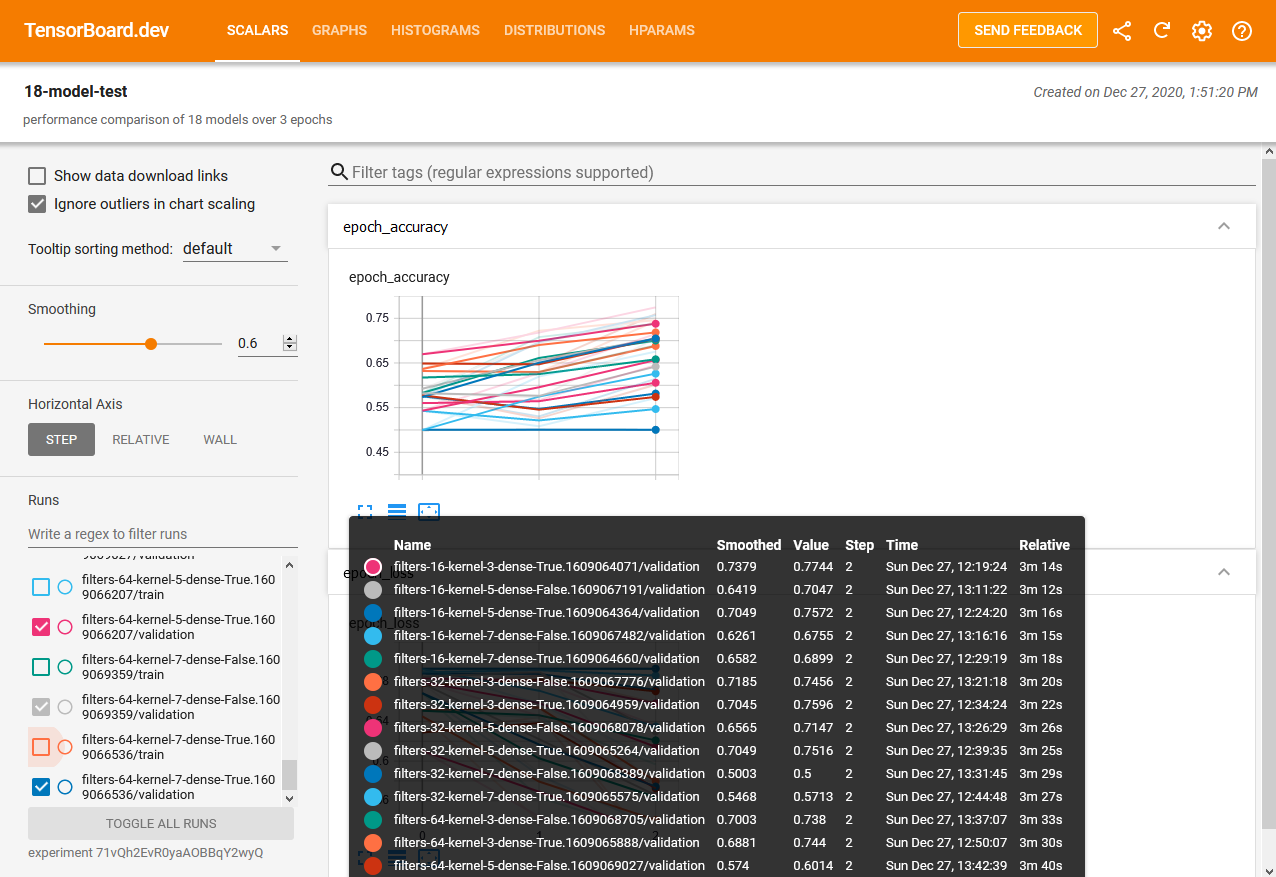

In [ ]:
!tensorboard dev upload --logdir logs --name "18-model-test" --description "performance comparison of 18 models over 3 epochs" --one_shot

The full result can be viewed here: https://tensorboard.dev/experiment/71vQh2EvR0yaAOBBqY2wyQ/

The best performance in terms of accuracy was by the 16/3/True model (16 filters, 3x3 kernel size and an additional dense layer) 

Other models that achieved similar performance were the 16/5/True and 32/3/True.



In [ ]:
sequential_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                           input_shape=(150,150,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 18, 18, 64)        3

In [ ]:
sequential_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
os.mkdir('/content/checkpoints/')

In [ ]:
s = sequential_model.fit(train_it,
              validation_data=test_it,
              steps_per_epoch=352,
              epochs=30,
              validation_steps=39, 
              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoints/',
                                                            save_best_only=True,
                                                            monitor='val_accuracy',mode='max')])

Epoch 1/30
352/352 [==============================] - 100s 281ms/step - loss: 0.6817 - accuracy: 0.5499 - val_loss: 0.5994 - val_accuracy: 0.6971
INFO:tensorflow:Assets written to: /content/checkpoints/assets
Epoch 2/30
352/352 [==============================] - 99s 281ms/step - loss: 0.6114 - accuracy: 0.6662 - val_loss: 0.5179 - val_accuracy: 0.7504
INFO:tensorflow:Assets written to: /content/checkpoints/assets
Epoch 3/30
352/352 [==============================] - 99s 281ms/step - loss: 0.5488 - accuracy: 0.7182 - val_loss: 0.4534 - val_accuracy: 0.7965
INFO:tensorflow:Assets written to: /content/checkpoints/assets
Epoch 4/30
352/352 [==============================] - 99s 280ms/step - loss: 0.5083 - accuracy: 0.7464 - val_loss: 0.4335 - val_accuracy: 0.7985
INFO:tensorflow:Assets written to: /content/checkpoints/assets
Epoch 5/30
352/352 [==============================] - 99s 282ms/step - loss: 0.4709 - accuracy: 0.7732 - val_loss: 0.3813 - val_accuracy: 0.8181
INFO:tensorflow:Assets

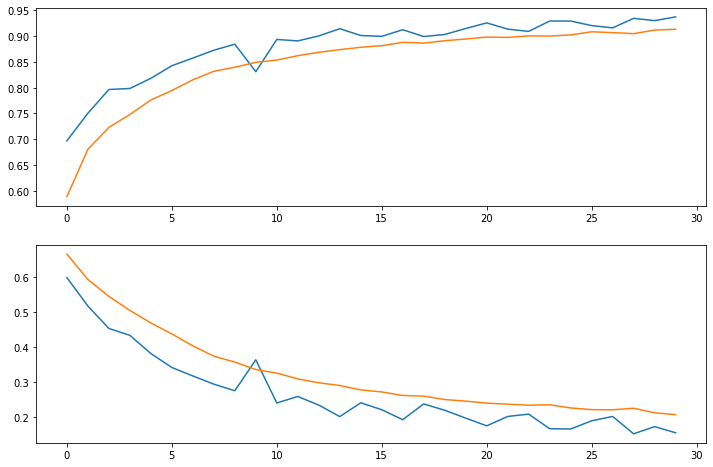

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(s.history['val_accuracy'])
plt.plot(s.history['accuracy'])
plt.subplot(212)
plt.plot(s.history['val_loss'])
plt.plot(s.history['loss'])


In [ ]:
sequential_model.evaluate(test_it,steps=39)

39/39 [==============================] - 6s 165ms/step - loss: 0.1532 - accuracy: 0.9375


[0.15321560204029083, 0.9375]

After 30 epochs (about an hour of training on a single GPU) the model has reached an accuracy of about 93.8% on the validation set. Looking at the plot for the loss it looks like we could train for longer and gotten even better results.  

Now let's see how our model performs when we feed it unlabeled pictures from the test folder.

In [ ]:
# unzip the test images

zip_ref2 = zipfile.ZipFile('/content/test1.zip', 'r')
zip_ref2.extractall('/content')
zip_ref2.close()

Now let's visualize some of the model's predictions

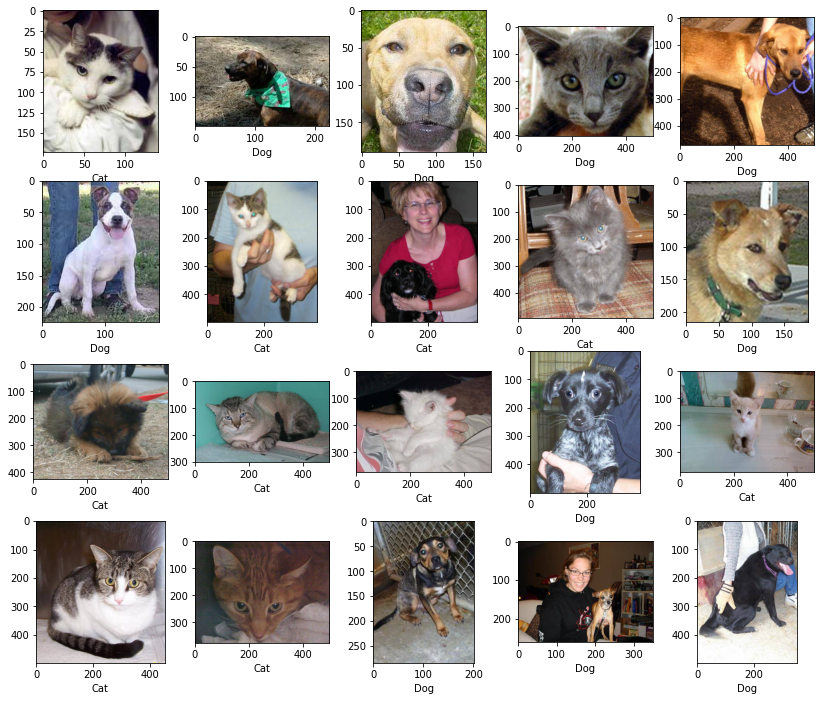

In [ ]:
from keras.preprocessing import image

base_dir = '/content/test1/'
plt.figure(figsize=(14,12)) 
for i, files in enumerate(random.sample(os.listdir(base_dir),len(os.listdir(base_dir)))[0:20]):

  img = image.load_img(base_dir+files, target_size=(150, 150),color_mode='grayscale')
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = sequential_model.predict(images, batch_size=10)

  imgs=mpimg.imread(base_dir+files)
  ax = plt.subplot(4,5,(i+1))
  if classes[0]>0.5:
    ax.set(xlabel='Dog')
    plt.imshow(imgs)
  else:
    ax.set(xlabel='Cat')
    plt.imshow(imgs)

The model got 17 out of 20 pictures right for this particular batch and it has mostly misclassified dogs for cats. In the two dog pictures that were classified as cats the features are relatively obscured, so this might be a reason for the result.

We'll also take a look at the feature maps produced by each layer, to see if we can get a hint at what the model points its attention at.

For this we will load an image, and use the outputs from our model's first convolutional layer.

In [ ]:
model = tf.keras.models.load_model(filepath='/content/checkpoints')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 18, 18, 64)        3

In [ ]:
model.layers[0]

In [ ]:
fm_conv_1 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

fm_conv_2 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[2].output)

In [ ]:
sample = random.sample(os.listdir(base_dir),1)

print(base_dir+sample[0])

/content/test1/3881.jpg


In [ ]:
imgg = tf.keras.preprocessing.image.load_img(base_dir+sample[0], target_size=(150, 150),color_mode='grayscale')
y = tf.keras.preprocessing.image.img_to_array(imgg)
y = np.expand_dims(y, axis=0)
imagee = np.vstack([y])

feature_maps_1 = fm_conv_1.predict(imagee)
feature_maps_2 = fm_conv_2.predict(imagee)

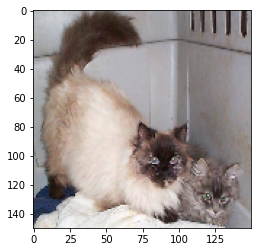

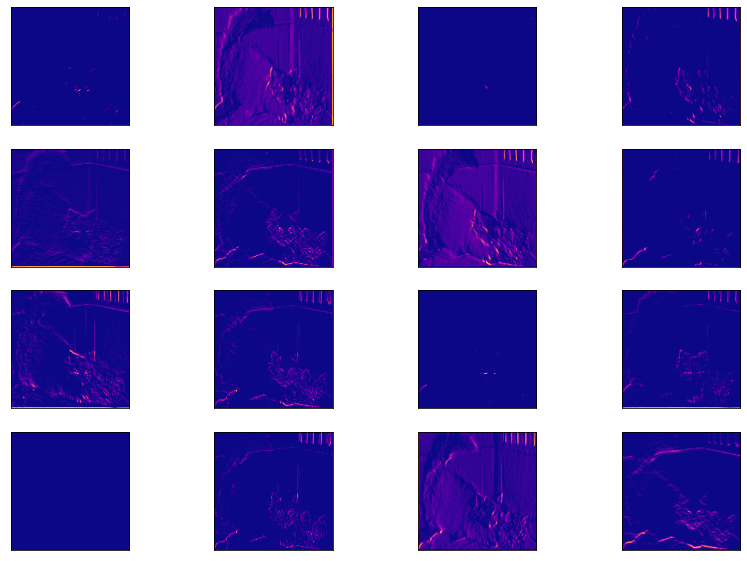

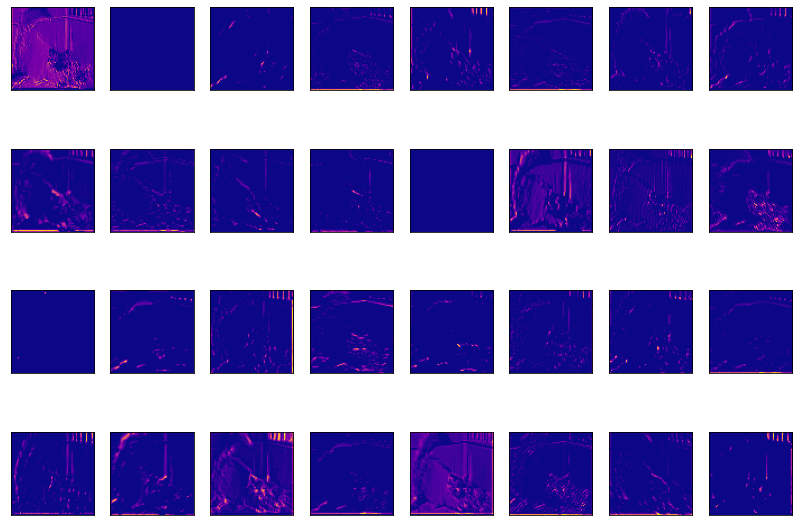

In [ ]:
square = 4
ix = 1

plt.figure(figsize=(8,4))
plt.imshow(tf.keras.preprocessing.image.load_img(base_dir+sample[0], target_size=(150, 150)))
plt.figure(figsize=(14,10))
for _ in range(square):
	for _ in range(square):
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(feature_maps_1[0, :, :, ix-1],cmap='plasma')
		ix += 1

ix2 = 1
plt.figure(figsize=(14,10))
for _ in range(4):
  for _ in range(8):
      ax = plt.subplot(4, 8, ix2)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps_2[0, :, :, ix2-1],cmap='plasma')
      ix2 += 1

The first convolutional layer outputs low-level features such as lines and edges. Also some feature maps focus more on the foreground and others on background. 

In conclusion, we achieved a reasonably low error rate (~6%), with a simple architecture and within a reasonably short training time (less than an hour).

For reference, the winning model ([OverFeat](https://https://arxiv.org/pdf/1312.6229.pdf)), had the same number of convolutional layers, but included additional dense and dropout layers and was trained for 80 epochs on the ImageNet 2012 dataset.